### BERT fine-tuning for document classification

### Global Variables

In [16]:
MODEL="bert-base-uncased"

### Installation

In [2]:
!pip install datasets
!pip install transformers

### All Imports

In [5]:
from datasets import load_dataset
import os
import re
import numpy as np 
from sklearn.metrics import accuracy_score
import transformers
from transformers import BertTokenizer, BertModel
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import torch
from torch import cuda
from tqdm import tqdm_notebook as tqdm
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import pandas as pd

### Emotion Dataset from Huggingface

In [ ]:
dataset=load_dataset('emotion')
#dataset = load_dataset("sem_eval_2018_task_1",'subtask5.english')

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

### Twitter Dataset for our Analysis

In [23]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
dataset=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/covid19_tweets.csv')

Mounted at /content/drive


In [24]:
X = dataset['text'].values

### TweetEval Dataset

In [4]:
task='emotion'
dataset=load_dataset('tweet_eval',task)

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3257 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1421 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/374 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [7]:
import pandas as pd
train_data=pd.DataFrame(dataset['train'])
test_data=pd.DataFrame(dataset['test'])
#val_data=pd.DataFrame(dataset['validation'])

In [8]:
train_X=train_data['text'].values
len(train_X)
train_labels=train_data['label'].values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()
le.fit(train_labels) 
y_train = le.transform(train_labels).reshape(-1, 1) # this is magic
ohe.fit(y_train)
train_y = ohe.transform(y_train).todense()
del y_train
del train_labels
del train_data

In [9]:
test_X=test_data['text'].values
test_labels=test_data['label'].values
le = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()
le.fit(test_labels) 
y_test = le.transform(test_labels).reshape(-1, 1) # this is magic
ohe.fit(y_test)
test_y = ohe.transform(y_test).todense()


In [10]:
del y_test
del test_labels
del test_data



## train data for semeval 2018 task 1

In [ ]:
#train_X=train_data['Tweet'] 
train_y=train_data.drop(columns=['ID','Tweet'])
train_X=dataset['train']['Tweet']
del train_data

In [ ]:
train_y=train_y.astype(int)

In [ ]:

#test_X=test_data['Tweet']
test_y=test_data.drop(columns=['ID','Tweet'])
test_X=dataset['test']['Tweet']
del test_data

In [ ]:
test_y=test_y.astype(int)

In [ ]:
print(len(train_X))
print(len(train_y))

6838
6838


## Model Init

### Run this cell for the first time

In [11]:
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

### Torch Datasets

- takes in inputs and outputs/labels
- interfaces with tokenizer
- handles batching

In [12]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

class MultiLabelDataset(torch.utils.data.Dataset):

    def __init__(self, text, labels, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.targets = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }
        
class NoLabelDataset(torch.utils.data.Dataset):

    def __init__(self, text, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = text
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
        }

### Bert Class

- first "layer" is a pre-trained BERT model
- you can add whatever layers you want after that

In [13]:
class BERTClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(BERTClass, self).__init__()
                   
        self.l1 = BertModel.from_pretrained(MODEL)
#         self.pre_classifier = torch.nn.Linear(768, 256)
        self.classifier = torch.nn.Linear(768, NUM_OUT)
#         self.dropout = torch.nn.Dropout(0.5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.Tanh()(pooler)
#         pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output
class AutoClass(torch.nn.Module):
    def __init__(self, NUM_OUT):
        super(AutoClass, self).__init__()
                   
        self.l1 = AutoModelForSequenceClassification.from_pretrained(MODEL)
#         self.pre_classifier = torch.nn.Linear(768, 256)
        self.classifier = torch.nn.Linear(768, NUM_OUT)
#         self.dropout = torch.nn.Dropout(0.5)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
#         pooler = self.pre_classifier(pooler)
#         pooler = torch.nn.Tanh()(pooler)
#         pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        output = self.softmax(output)
        return output

### Helpful Functions


Loss

- This task is binary, so it uses binary crossentropy loss
- Tasks with more labels will use categorical crossentropy
- Tasks that don't have labels, but rather have distributions should use KL divergence
- Tasks that don't have distributions should use something like RMSE loss

Train

- Steps through the data batch by batch
- grabs ids, masks, and token_type_ids which are required inputs for BERT
- inputs are passed through the model, compared to targets, computes loss function, backprops

Validation

- Takes a model, passes inputs
- Need to use the targets from here because they are potentially shuffled!

In [14]:
def loss_fn(outputs, targets):
    #print(outputs,targets)
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train(model, training_loader, optimizer):
    model.train()
    for data in tqdm(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return outputs
    
def validation(model, testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            fin_targets.extend(targets)
    return torch.stack(fin_outputs), torch.stack(fin_targets)
def predict(model, testing_loader):
    model.eval()
    fin_outputs=[]
    with torch.no_grad():
        for data in tqdm(testing_loader):
            #targets = data['targets']
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
            outputs = torch.sigmoid(outputs).cpu().detach()
            fin_outputs.extend(outputs)
            #fin_targets.extend(targets)
    return torch.stack(fin_outputs)#, torch.stack(fin_targets)

## Training

- hyperparameters
- setup dataset
- setup parameters
- setup dataloader

In [18]:
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 3
NUM_OUT = 4 # binary task
LEARNING_RATE = 2e-05
i=0
for txt in train_X:
  train_X[i]=preprocess(txt)
  i+=1
tokenizer=BertTokenizer.from_pretrained(MODEL)
training_data = MultiLabelDataset(train_X, torch.from_numpy(train_y), tokenizer, MAX_LEN)
test_data = MultiLabelDataset(test_X, torch.from_numpy(test_y), tokenizer, MAX_LEN)

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    

training_loader = torch.utils.data.DataLoader(training_data, **train_params)
testing_loader = torch.utils.data.DataLoader(test_data, **test_params)
model = BERTClass(NUM_OUT)
model.to(device)    

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    outputs = train(model, training_loader, optimizer)
    #print(f'Epoch: {epoch}, Loss:  {loss.item()}')  
    guess, targs = validation(model, testing_loader)
    guesses = torch.max(guess, dim=1)
    targets = torch.max(targs, dim=1)
    print('accuracy on test set {}'.format(accuracy_score(guesses.indices, targets.indices)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/23 [00:00<?, ?it/s]

accuracy on test set 0.7565095003518649


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/51 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/23 [00:00<?, ?it/s]

accuracy on test set 0.757213230119634


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/51 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/23 [00:00<?, ?it/s]

accuracy on test set 0.7860661505981703


### Free up Memory

In [19]:
del train_X
del test_X
del train_y
del test_y
del training_data
del test_data
del training_loader
del testing_loader
del guesses
del targets

## Prediction

In [21]:
trained_model=model
del model

In [25]:
tokenizer=BertTokenizer.from_pretrained(MODEL)
real_test_data = NoLabelDataset(X, tokenizer, MAX_LEN)

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }    
real_testing_loader = torch.utils.data.DataLoader(real_test_data, **test_params)

In [26]:
guess = predict(trained_model, real_testing_loader)
#guesses = torch.max(guess, dim=1)
#print('accuracy on test set {}'.format(accuracy_score(guesses.indices, targets.indices)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/2799 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [59]:
from scipy.special import softmax
emotion_df = pd.DataFrame(0, index=np.arange(len(guess)), columns=labels)

#print(emotion_count[0])
for g in guess:
  score = g.numpy()
  score=softmax(score)
  emotion_df[labels[np.argmax(score)]]=1

KeyboardInterrupt: ignored

In [65]:
emotion=[]
for g in guess:
  score = g.numpy()
  score=softmax(score)
  emotion.append(labels[np.argmax(score)])

In [97]:
emotion_score=[[]]
for g in guess:
  score = g.numpy()
  emotion_score.append(softmax(score))

In [104]:
emotion_score[2]

array([0.29391184, 0.2350201 , 0.23493569, 0.23613226], dtype=float32)

In [99]:
labels

['anger', 'joy', 'optimism', 'sadness']

In [105]:
dataset[['anger','joy','optimism','sadness']]=emotion_score[1:]

In [130]:
dataset.sort_values(by=['date'],inplace=True)

In [62]:
le.fit(train_labels) 
y_train = le.transform(train_labels).reshape(-1, 1) # this is magic
ohe.fit(y_train)
train_y = ohe.transform(y_train).todense()

ValueError: ignored

In [29]:
print(labels)

['anger', 'joy', 'optimism', 'sadness']


In [68]:
emotion_df=pd.DataFrame(data=emotion,columns=['emotion'])

In [74]:
emotion_df.value_counts()

emotion 
joy         81751
anger       64085
sadness     32944
optimism      328
dtype: int64

In [78]:
emotion_df.describe()

,emotion
count,179108
unique,4
top,joy
freq,81751


In [80]:
dataset['emotion']=emotion_df

In [85]:
dataset[['user_location','emotion']]

,user_location,emotion
0,astroworld,anger
1,"New York, NY",anger
2,"Pewee Valley, KY",anger
3,Stuck in the Middle,joy
4,Jammu and Kashmir,joy
...,...,...
179103,"Ilorin, Nigeria",anger
179104,Ontario,joy
179105,🇨🇦 Canada,anger
179106,New York City,anger


In [119]:
dataset[['user_location']].value_counts()

user_location         
india                     3842
united states             2457
worldwide                 1738
new delhi, india          1731
mumbai, india             1406
                          ... 
liverpool kulon              1
liverpool in europe          1
liverpool england            1
liverpool city council       1
lordshill southampton        1
Length: 26036, dtype: int64

In [118]:
dataset['user_location']=dataset['user_location'].str.lower()
dataset[['loc1','loc2']]=dataset['user_location'].str.split(',',n=1, expand=True)


In [120]:
dataset[['loc2']].value_counts()

loc2           
 india             9095
 usa               5119
 england           3555
 ca                3332
 ny                2125
                   ... 
 on 🇨🇦                1
 fl ⚓️🏝🛳🏠🏢🌅⛴          1
 abuja, nigeria       1
 on, canada           1
🇬🇧🇪🇺 for work         1
Length: 4601, dtype: int64

In [121]:
mask = (dataset['loc2'] == 'india') | (dataset['loc2'] =='usa')

In [132]:
dataset

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,emotion,loc1,loc2,anger,joy,optimism,sadness
17175,Jessica Luther Rummel,"denton, texas",Mother. Partner. Scholar. Activist. Alchemist....,2020-07-05 03:28:16,234,28,220,False,2020-07-24 23:47:08,PROTESTORS NEEDED 6PM-10PM DAILY (NOW). 1450 E...,NaN,Twitter Web App,False,joy,denton,texas,0.234784,0.294793,0.235554,0.234869
17174,Dr. Lipi #TrustDrFauci Roy,"new york, usa",@NBCNews @MSNBC @Forbes Medical Contributor | ...,2009-10-11 18:46:51,12485,4603,38120,True,2020-07-24 23:47:12,Always honored to speak w @NicolleDWallace abo...,['covid19'],Twitter Web App,False,sadness,new york,usa,0.234835,0.235241,0.235095,0.294829
17173,Patty Hayes,"seattle, wa",Director of Public Health - Seattle & King Cou...,2017-07-07 18:56:50,718,162,2276,False,2020-07-24 23:47:12,"Excellent partnership to prevent #COVID19, tha...",['COVID19'],Twitter for Android,False,joy,seattle,wa,0.235177,0.294583,0.235338,0.234902
17172,Clive Gorman,"victoria, british columbia",Marketing Director @CNEGames for @idlechampion...,2011-12-23 02:02:35,597,224,23824,False,2020-07-24 23:47:12,Don't take your eye off the ball. There are st...,['COVID19'],Twitter for Android,False,joy,victoria,british columbia,0.239036,0.269476,0.241188,0.250300
17171,Tristyn Russelo,"alberta, canada",NaN,2017-06-14 22:01:54,5,68,57,False,2020-07-24 23:47:13,"Apparently, at the Timberlea @saveonfoods stor...",NaN,Twitter Web App,False,sadness,alberta,canada,0.240844,0.234815,0.235718,0.288623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166660,Dirk Haussecker,rna world,RNA(i) Therapeutics Investor-Scientist who lov...,2011-11-10 12:00:58,9341,339,7276,False,2020-08-30 09:07:25,"In Germany, we have ~1-3 deaths/day while dail...",NaN,Twitter Web App,False,joy,rna world,None,0.235192,0.294419,0.235536,0.234854
166659,Natalie B 🔶️,england,single mum. Lib Dem. outspoken on Freedom of s...,2019-01-06 14:22:49,439,586,165,False,2020-08-30 09:07:25,I do find it interesting how the #Tories are b...,['Tories'],Twitter for Android,False,sadness,england,None,0.245783,0.246070,0.253161,0.254986
166658,Keith Bishop 👨‍👨‍👧‍👦 🏳️‍🌈,"newman university, uk","Foster Dad, Youth Worker & Senior Lecturer (Ch...",2015-06-20 10:56:58,1244,667,1140,False,2020-08-30 09:07:26,Concerns have been raised that return to unive...,['COVID19'],Twitter for iPad,False,sadness,newman university,uk,0.244661,0.235900,0.238270,0.281169
166657,Kings Place,"kings cross, london","An open, multi-arts venue presenting an advent...",2009-02-26 12:16:47,18930,6213,23986,False,2020-08-30 09:07:34,⏰ Today @ 11:30!\nTune in for the latest #Bach...,['Bach'],Twitter Web App,False,anger,kings cross,london,0.268694,0.253983,0.241060,0.236263


In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

TypeError: ignored

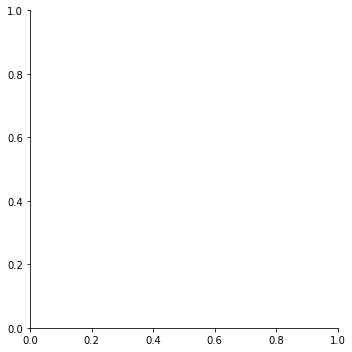

In [138]:
sns.displot(data=dataset, kind="kde", x="emotion")

In [ ]:
dataset[]

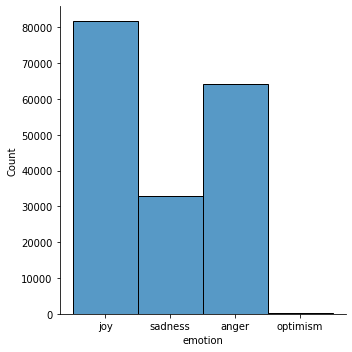

In [137]:
sns.displot(dataset['emotion'])
plt.savefig('emotion_frequency.pdf')

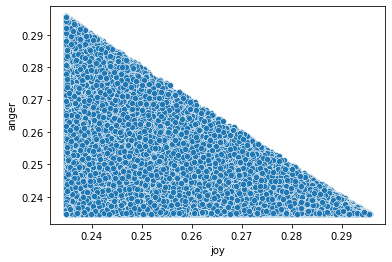

In [142]:
sns.scatterplot(data=dataset,x=dataset['joy'],y=dataset['anger'])

In [143]:
dataset.to_csv('dataset.csv')

In [ ]:
dataset=